## INTRODUCTION

### Welcome to my first and one of my favourite NLP analysis!

In these times of quarantine, online shopping have shown to be one of the greatest stress-busters for women!😍 <br>
While all of us are on our journeys to becoming shopaholics or broke 😁, let us analyze the importance of CUSTOMER REVIEWS while shopping online!

As per facts, **61%** of customers read online reviews before making a purchase decision, and they are now essential for *e-commerce sites*. Also, according to Reevoo, reviews produce an average **18%** uplift in sales. Hence ***USER REVIEWS*** are proven sales drivers, and something the majority of customers will definitely want to see before deciding to make a purchase.

<img src="https://media.giphy.com/media/cqw80XStn460U/giphy.gif">



**Customer segmentation**, on the other hand, helps in targeted marketing, new customer acquisitions and hence more successful campaigns. 
Today we are going to perform Customer Segmentation by clustering the valuable **Customer Reviews**.

Most simplified methods have been used in my notebook to enable ease of understanding for beginners such as myself!

In this project you will also get a glimpse of:
- Text preprocessing for NLP (Stopwords removal, Lemmatization, part-of-speech tagging), 
- Sentiment analysis (vader sentiment)
- Dimensionality reduction (pca+tsne)
- Clustering (K-means)
- Topic Modeling (LDA)
<br><br>
working together to provide **meaningful insights**!
<br>
LET'S DIVE IN!

### 1. Importing data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
import time

# nltk
import nltk
from nltk.corpus import stopwords
stoplist= stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# Enable logging
import logging
logging.basicConfig(level= logging.INFO)

# You will find more libraries as they come in use!

In [2]:
df= pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv", index_col=0)
df.columns= df.columns.str.replace(" ", "_")
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 2. Feature Engineering

In [3]:
# Relation between Division name, Department name and Class name? 
df[['Division_Name','Department_Name','Class_Name']].groupby(['Division_Name','Department_Name','Class_Name']).agg('count')

Empty DataFrame
Columns: []
Index: [(General, Bottoms, Casual bottoms), (General, Bottoms, Jeans), (General, Bottoms, Pants), (General, Bottoms, Shorts), (General, Bottoms, Skirts), (General, Dresses, Dresses), (General, Jackets, Jackets), (General, Jackets, Outerwear), (General, Tops, Blouses), (General, Tops, Fine gauge), (General, Tops, Knits), (General, Tops, Sweaters), (General, Trend, Trend), (General Petite, Bottoms, Jeans), (General Petite, Bottoms, Pants), (General Petite, Bottoms, Skirts), (General Petite, Dresses, Dresses), (General Petite, Intimate, Lounge), (General Petite, Jackets, Jackets), (General Petite, Jackets, Outerwear), (General Petite, Tops, Blouses), (General Petite, Tops, Fine gauge), (General Petite, Tops, Knits), (General Petite, Tops, Sweaters), (General Petite, Trend, Trend), (Initmates, Intimate, Chemises), (Initmates, Intimate, Intimates), (Initmates, Intimate, Layering), (Initmates, Intimate, Legwear), (Initmates, Intimate, Lounge), (Initmates, Intimate, Sleep), (Initmates, Intimate, Swim)]

In [4]:
# Since the reviews is our main content, dropping rows where 'Review Text' is null
df.dropna(subset=['Review_Text'], inplace=True)
df.shape

(22641, 10)

In [5]:
# Review word count
df['rev_word_count']= df['Review_Text'].apply(lambda x: len(x.strip().split()))

# Unique word count
df['unique_word_count']= df['Review_Text'].apply(lambda x: len(set(str(x).split())))

In [6]:
# Bucketing Clothing ID's with 1 or 2 count

clothing_id_to_combine=[]
for val, cnt in df.Clothing_ID.value_counts().iteritems():
    # If that Clothing_ID is present less than 1%(~200) of the total data, club it into '000' (default) id
    if(cnt<200):         
        clothing_id_to_combine.append(val)        

print("# of clothing ID's clubbed: ",len(clothing_id_to_combine))

df['new_clothingID']= df.Clothing_ID.apply(lambda x: '000' if x in clothing_id_to_combine else x)
df.new_clothingID.value_counts(normalize=True)

# of clothing ID's clubbed:  1151


000     0.542997
1078    0.043593
862     0.034362
1094    0.032463
1081    0.024778
872     0.022923
829     0.022614
1110    0.020803
868     0.018285
895     0.016960
936     0.015370
867     0.014708
850     0.014310
1095    0.014266
863     0.012853
1059    0.012676
1077    0.012676
1086    0.012499
1080    0.012367
860     0.012190
1083    0.010777
861     0.010070
873     0.009849
1092    0.009673
828     0.009408
1033    0.009364
927     0.009143
1056    0.009099
820     0.008922
Name: new_clothingID, dtype: float64

### 3. Sentiment Analysis

Calibrating Title and Review sentiment scores using [VADER](https://github.com/cjhutto/vaderSentiment) Sentiment! <br>
VADER (Valence Aware Dictionary and sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In [7]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 1.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer= SentimentIntensityAnalyzer()

# Try it out!
vs= analyzer.polarity_scores("Vader sentiment looks interesting, I have high hopes!")
print(vs)

{'neg': 0.0, 'neu': 0.509, 'pos': 0.491, 'compound': 0.6996}


The **compound score** obtained from valence scores is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

In [9]:
df['review_sentiment']= [analyzer.polarity_scores(line)['compound'] for line in df['Review_Text']]

After analyzing certain Title sentiments, we notice that titles with 0 scores consist of positive, negative and neutral sentiments:

*Negative sentiments with 0 score*:<br>
Falls flat  >>>>> 0.0<br>
Runs short  >>>>> 0.0<br>

*Positive sentiments with 0 score*:<br>
Must have  >>>>> 0.0<br>
Comfy  >>>>> 0.0<br>
Stylish and versatile!  >>>>> 0.0 <br>

*Neutral sentiments with 0 score*:<br>
Simple, stylish, lovely-runs a bit big  >>>>> 0.0<br>
Some things you should know...  >>>>> 0.0<br>
Mehh  >>>>> 0.0<br>
Neutral blue  >>>>> 0.0<br>

**Hence we have assigned score '0.0' score to 'No title' above.**

In [10]:
# Title provides extra insight of the sentiment of the customer while writing the review. Hence we will also obtain Title sentiment alongwith review sentiment score.
# However 13% reviews don't have a Title. Hence filling in the null values with 'no title' and assigning it 0(neutral) sentiment

df.Title.fillna('no title', inplace=True)
df['title_sentiment']= df['Title'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if str(x)!= 'no title' else 0.0)

for index, row in df[100:120].iterrows():
    print(row['Title']," >>>>>", row['title_sentiment'])

Not a fan  >>>>> -0.2411
no title  >>>>> 0.0
Excited ... but ...  >>>>> 0.1779
Beautiful shirt but runs small!  >>>>> 0.4102
Beautiful  >>>>> 0.5994
Perfect fall shirt!  >>>>> 0.6114
no title  >>>>> 0.0
Poor quality  >>>>> -0.4767
An almost for me...  >>>>> 0.0
Beautiful, stunning, cozy top!  >>>>> 0.8221
Cute and comfy  >>>>> 0.4588
Disappointing quality  >>>>> -0.4939
Cute tee  >>>>> 0.4588
Very vintage feel  >>>>> 0.0
no title  >>>>> 0.0
Awkward fitting  >>>>> -0.1531
Cozy casual - perfect for fall  >>>>> 0.6705
The perfect striped t  >>>>> 0.5719
no title  >>>>> 0.0
no title  >>>>> 0.0


In [11]:
df['total_sentiment_score']= df['title_sentiment']+ df['review_sentiment']

In [12]:
# Golden rule: Save up the original dataframe before encoding!
df_orig= df.copy()
df_orig.shape 

# df= df_orig.copy()

(22641, 16)

### Feature Encoding and prepping up our data for clustering!

In [13]:
# Dropping text columns- we have already used them to calcuate the total sentiment score

df.drop(columns=['Review_Text','Title','Clothing_ID','review_sentiment','title_sentiment'], inplace=True)

In [14]:
# Deciding on categorical columns- object datatype -very slow processing

cat_cols= ['Division_Name','Department_Name','Class_Name','new_clothingID']
for col in cat_cols:
    print(col," has categories:", df[col].nunique())
    df[col]= df[col].astype('category')

Division_Name  has categories: 3
Department_Name  has categories: 6
Class_Name  has categories: 20
new_clothingID  has categories: 29


In [15]:
# Binary encoding our categorical columns

import category_encoders as ce

be= ce.BinaryEncoder(cols= cat_cols,drop_invariant=True).fit(df) 

df= be.transform(df)

## Clustering Begins!

After certain experiments,it is evident that pca followed by tsne gives most identifiable and clear clusters in low dimensions. Refer [example](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) below:

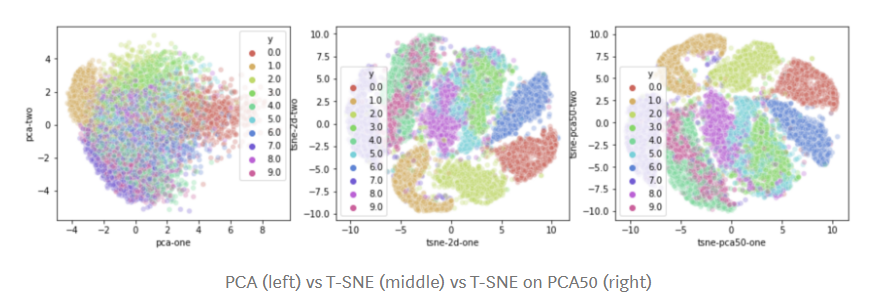

In [16]:
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.cluster import KMeans
import pylab as pl
%matplotlib inline
import matplotlib.pyplot as plt

Note: While optimizing TSNE- Since intuition behind perplexity(K) is how many neighbors each data point can “sense”, it is widely accepted that K~ N^(1/2). Hence in our case, K~150

In [17]:
pca_tsne= Pipeline([("pca", PCA(n_components= 0.90, random_state=33)),
                    ("tsne", TSNE(n_components=2,
                                  perplexity= 170,
                                  random_state=33, 
                                  learning_rate= 350, 
                                  n_iter= 5000,
                                  n_jobs=-1,
                                  n_iter_without_progress=150,
                                  verbose=1))])
t0= time.time()
df_pca_tsne_reduced= pca_tsne.fit_transform(df)
t1= time.time()

print("pca+tsne took:{:.1f}s ".format(t1-t0))

[t-SNE] Computing 511 nearest neighbors...
[t-SNE] Indexed 22641 samples in 0.016s...
[t-SNE] Computed neighbors for 22641 samples in 2.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22641
[t-SNE] Computed conditional probabilities for sample 2000 / 22641
[t-SNE] Computed conditional probabilities for sample 3000 / 22641
[t-SNE] Computed conditional probabilities for sample 4000 / 22641
[t-SNE] Computed conditional probabilities for sample 5000 / 22641
[t-SNE] Computed conditional probabilities for sample 6000 / 22641
[t-SNE] Computed conditional probabilities for sample 7000 / 22641
[t-SNE] Computed conditional probabilities for sample 8000 / 22641
[t-SNE] Computed conditional probabilities for sample 9000 / 22641
[t-SNE] Computed conditional probabilities for sample 10000 / 22641
[t-SNE] Computed conditional probabilities for sample 11000 / 22641
[t-SNE] Computed conditional probabilities for sample 12000 / 22641
[t-SNE] Computed conditional probabilities for sa

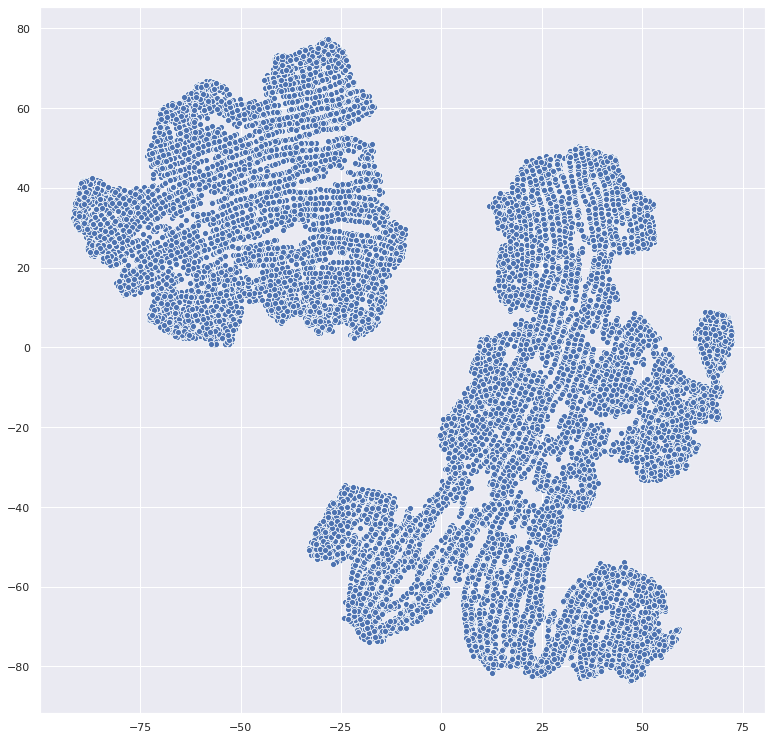

In [18]:
sns.set(rc= {'figure.figsize': (13,13)})
sns.scatterplot(df_pca_tsne_reduced[:,0], df_pca_tsne_reduced[:,1])
plt.show()

## K-Means Clustering

One can easily spot the clusters above. 
Now let us have the opinion of K-Means as well! 
We will color by K-Means clustering to figure out if both the algorithms agree on the clustering!

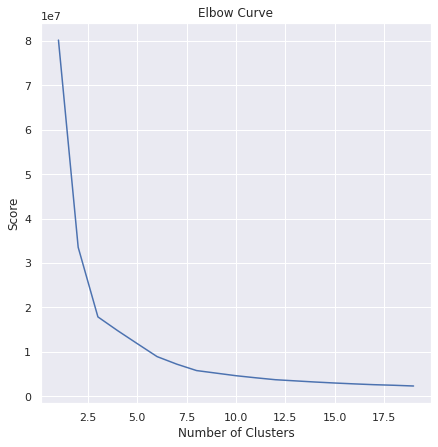

Plotting the Elbow curve took:10.8s 


In [19]:
review_data_std = stats.zscore(df_pca_tsne_reduced)
review_data_std = np.array(review_data_std)

sns.set(rc= {'figure.figsize': (7,7)})
number_of_clusters = range(1,20)

t0= time.time()
kmeans = [KMeans(n_clusters=i,max_iter=1000,random_state=33,n_jobs=-1) for i in number_of_clusters]
score = [-1*kmeans[i].fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced) for i in range(len(kmeans))]
t1= time.time()

pl.plot((number_of_clusters),score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

In [20]:
k_means_test = KMeans(n_clusters=3, max_iter=1500, random_state=33,verbose=1, n_jobs=-1)

#fitting on your model
-1*k_means_test.fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced)
y_pred= k_means_test.labels_

# Assigning cluster labels to each data point
df_orig['klabels'] = k_means_test.labels_

Initialization complete
Iteration 0, inertia 37119472.0
Iteration 1, inertia 31017766.0
Iteration 2, inertia 28640278.0
Iteration 3, inertia 24248238.0
Iteration 4, inertia 19029200.0
Iteration 5, inertia 17941246.0
Iteration 6, inertia 17875954.0
Iteration 7, inertia 17867746.0
Converged at iteration 7: center shift 0.13417726755142212 within tolerance 0.17703847656250002
Initialization complete
Iteration 0, inertia 28654138.0
Iteration 1, inertia 18330126.0
Iteration 2, inertia 17876482.0
Iteration 3, inertia 17867738.0
Converged at iteration 3: center shift 0.1351797729730606 within tolerance 0.17703847656250002
Initialization complete
Iteration 0, inertia 34823652.0
Iteration 1, inertia 17949350.0
Iteration 2, inertia 17866964.0
Converged at iteration 2: center shift 0.053987473249435425 within tolerance 0.17703847656250002
Initialization complete
Iteration 0, inertia 30770318.0
Iteration 1, inertia 23126440.0
Iteration 2, inertia 18323318.0
Iteration 3, inertia 17896814.0
Iteratio

In [21]:
# Analyzing 
size_of_each_cluster= df_orig.groupby('klabels').size().reset_index()
size_of_each_cluster.columns = ['klabels','number_of_points']
size_of_each_cluster['percentage'] = (size_of_each_cluster['number_of_points']/np.sum(size_of_each_cluster['number_of_points']))*100

print(size_of_each_cluster)

   klabels  number_of_points  percentage
0        0              6935   30.630273
1        1              8650   38.205026
2        2              7056   31.164701


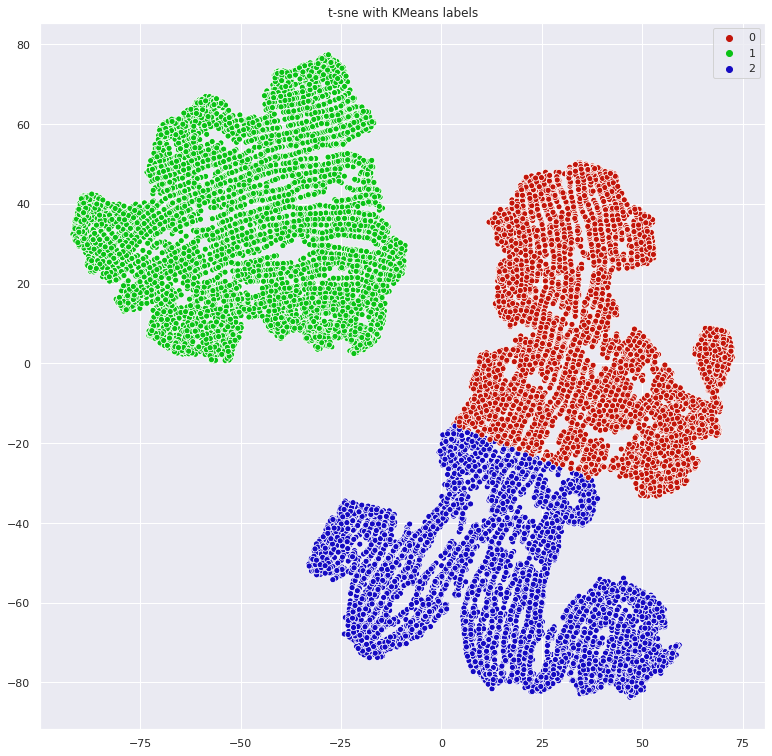

In [22]:
palette = sns.hls_palette(3, l=.4, s=.9)

sns.set(rc= {'figure.figsize': (13,13)})
sns.scatterplot(df_pca_tsne_reduced[:,0], df_pca_tsne_reduced[:,1], hue= y_pred, legend='full', palette=palette)
plt.title("t-sne with KMeans labels")
plt.show()

As we can see, the K-Means clusters also closely represents the clusters created by PCA and TSNE. Together it has produced some classic clustering. <br>
Apart from clustering the reviews together, we would also like to understand ***'meaning of each cluster'***. This can be achieved via **TOPIC MODELING**. <br>

Hence, now we will attempt to find the most significant words in each cluster. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving **keywords** to quickly identify the themes of the cluster.

## Topic Modeling- Latent Dirichlet Allocation(LDA) 

For topic modeling, we will use the infamous LDA (Latent Dirichlet Allocation) algorithm. In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.

STEP 1: Preprocessing text - Tokenizing sentences, stopwords removal and lemmatization

In [23]:
def get_pos_tag(tag):
    """This function is used to get the part-of-speech(POS) for lemmatization"""
    
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN #default case

In [24]:
import re
def preprocess(text):
    """ 1. Removes Punctuations
        2. Removes words smaller than 3 letters
        3. Converts into lowercase
        4. Lemmatizes words
        5. Removes Stopwords
    """   
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(text)
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]
    
    # Lemmatize    
    pos_tags=nltk.pos_tag(word_tokens)
#     print(pos_tags)
    doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]
    doc_words= [word for word in doc_words if word not in stoplist]
    
    return doc_words

df_clean = df_orig['Review_Text'].apply(preprocess)
df_clean.head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happen, find, stor...
2    [high, hope, dress, really, want, work, initia...
3    [love, love, love, jumpsuit, flirty, fabulous,...
4    [shirt, flatter, adjustable, front, perfect, l...
Name: Review_Text, dtype: object

STEP 2: DATA CLEANING- PROCURE ONLY NOUNS AND ADJECTIVES TO OBTAIN MEANINGFUL TOPICS!

In [25]:
# Adding business stopwords to exclude

common_terms= ["wear","look","ordered","color","purchase","order"]

stoplist= stoplist+ common_terms

In [26]:
# Tried multiple parts of speech and obtained best topic results using Nouns and Adjectives!
def get_nouns_adjs(series):
    
    " Topic Modeling using only nouns and adjectives"
    
    pos_tags= nltk.pos_tag(series)
    all_adj_nouns= [word for (word, tag) in pos_tags if (tag=="NN" or tag=="NNS" or tag=="JJ")] 
    return all_adj_nouns

df_nouns_adj = df_clean.apply(get_nouns_adjs)

Step 3: Add bigrams to your corpus using Word2vec model from gensim

In [27]:
# Importing gensim related libraries
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec

In [28]:
docs= list(df_nouns_adj)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)

In [29]:
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(docs)

In [30]:
# Checkout most frequent bigrams :
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stopwords.words('english'):
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(20):
    print(key,">>>>", counts)

b'true_size' >>>> 1317
b'look_great' >>>> 735
b'size_small' >>>> 731
b'order_size' >>>> 629
b'size_size' >>>> 524
b'usual_size' >>>> 496
b'fabric_soft' >>>> 391
b'many_compliment' >>>> 364
b'order_small' >>>> 347
b'soft_comfortable' >>>> 347
b'love_dress' >>>> 346
b'skinny_jean' >>>> 337
b'regular_size' >>>> 333
b'wear_size' >>>> 318
b'material_soft' >>>> 314
b'super_soft' >>>> 313
b'size_large' >>>> 300
b'dress_look' >>>> 292
b'petite_size' >>>> 287
b'fit_true' >>>> 279


**Feeding the bigrams into a Word2Vec model produces more meaningful bigrams**

In [31]:
w2vmodel = Word2Vec(bigram_model[docs], size=100, sg=1, hs= 1, seed=33, iter=35)
bigram_counter = Counter()

for key in w2vmodel.wv.vocab.keys():
    if key not in stoplist:
        if len(str(key).split("_")) > 1:
            bigram_counter[key] += w2vmodel.wv.vocab[key].count

for key, counts in bigram_counter.most_common(30):
    print(key,">>>>> " ,counts)

many_compliment >>>>>  364
skinny_jean >>>>>  337
body_type >>>>>  229
sale_price >>>>>  220
full_price >>>>>  209
first_time >>>>>  205
local_retailer >>>>>  168
broad_shoulder >>>>>  157
local_store >>>>>  149
base_review >>>>>  137
light_weight >>>>>  131
worth_price >>>>>  127
cami_underneath >>>>>  118
previous_review >>>>>  110
spring_summer >>>>>  108
last_year >>>>>  101
lot_compliment >>>>>  97
read_review >>>>>  97
pencil_skirt >>>>>  90
athletic_build >>>>>  89
right_place >>>>>  89
fall_winter >>>>>  88
denim_jacket >>>>>  88
price_point >>>>>  79
right_amount >>>>>  79
real_life >>>>>  76
tank_underneath >>>>>  75
hand_wash >>>>>  72
ton_compliment >>>>>  71
year_round >>>>>  63


**Checkout some cool stuff from the bigram model!**

In [32]:
# MostOften mentioned along with the word 'pregnant'
w2vmodel.most_similar(positive= ['pregnant'])

[('baby_bump', 0.6001793742179871),
 ('pregnancy', 0.5054532289505005),
 ('trimester', 0.4785056412220001),
 ('maternity', 0.4486354887485504),
 ('tenty', 0.4359229803085327),
 ('month_pregnant', 0.4337391257286072),
 ('grow', 0.43000712990760803),
 ('accommodate', 0.42588865756988525),
 ('parachute', 0.40355291962623596),
 ('twin', 0.3898429870605469)]

In [33]:
# Which color is to 'work' as 'white' is to 'wedding'
w2vmodel.wv.most_similar(['work','white'], ['wedding'], topn=5)

[('black', 0.5764913558959961),
 ('cute', 0.427170991897583),
 ('shirt', 0.4153817892074585),
 ('love', 0.41501089930534363),
 ('dressed', 0.4101262092590332)]

In [34]:
w2vmodel.wv.most_similar(['price','steal'], ['discount'], topn=5)

[('steep', 0.4605957865715027),
 ('tissue', 0.40277281403541565),
 ('quality', 0.3668252229690552),
 ('thin', 0.3655858635902405),
 ('retail', 0.36438679695129395)]

In [35]:
# What is a 'deal_breaker', if 'quality'is 'worth_penny' 
w2vmodel.wv.most_similar(positive=["deal_breaker","quality"], negative=["worth_penny"], topn=3)

[('fabric', 0.4748133718967438),
 ('overall', 0.4284329116344452),
 ('line', 0.4052583575248718)]

Step 4: Create a dictionary and corpus for input to our LDA model. Filter out the most common and uncommon words. 

In [36]:
dictionary= Dictionary(data_words_bigrams)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1528
Number of documents: 22641


Step 5: Train your LDA model- Topic Modeling

In [37]:
from gensim.models.ldamulticore import LdaMulticore

t0= time.time()
passes= 150
np.random.seed(1) # setting up random seed to get the same results
ldamodel= LdaMulticore(corpus, 
                    id2word=dictionary, 
                    num_topics=4, 
#                   alpha='asymmetric', 
                    chunksize= 4000, 
                    batch= True,
                    minimum_probability=0.001,
                    iterations=350,
                    passes=passes)                    

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 150  passes:  1994.0993559360504  seconds


STEP 5: *Ta-Daa!* Here are your Topics!

In [38]:
ldamodel.show_topics(num_words=25, formatted=False)

[(0,
  [('size', 0.060767967),
   ('waist', 0.02655347),
   ('petite', 0.025113368),
   ('dress', 0.02387363),
   ('length', 0.02302755),
   ('skirt', 0.019782651),
   ('short', 0.019427186),
   ('order', 0.017767658),
   ('pant', 0.016084133),
   ('small', 0.015682753),
   ('regular', 0.013427975),
   ('great', 0.0134193655),
   ('jean', 0.013121252),
   ('look', 0.012053078),
   ('wear', 0.011322987),
   ('perfect', 0.011312971),
   ('fit', 0.010843701),
   ('little', 0.01014654),
   ('fabric', 0.01014099),
   ('hip', 0.009477502),
   ('right', 0.009041619),
   ('love', 0.008599685),
   ('work', 0.008109461),
   ('stretch', 0.008074226),
   ('nice', 0.0075947186)]),
 (1,
  [('shirt', 0.03288952),
   ('color', 0.022483028),
   ('white', 0.017515432),
   ('little', 0.017274875),
   ('look', 0.016398937),
   ('wear', 0.015687356),
   ('size', 0.015604746),
   ('cute', 0.015386382),
   ('fabric', 0.015203026),
   ('nice', 0.0132665485),
   ('soft', 0.012742951),
   ('love', 0.012220826),

<!-- **Well, what are the Topics saying??**

**TOPIC 0**- *Top wear* <br>
(Items) Top, sweater, shirt, jacket, tank, tee ; (And related stuff): color(white, black, blue), look, fabric(soft, material), price (sale), fit, quality <br>

**TOPIC 1**- *Attributes of clothes*
size(small, medium, large, petite, big, short, little,  length, regular,  lb, true), fit (tight, true), fabric, color, fittings/sizing in different body parts(arm, waist, shoulder, bottom, side), return if not a good one <br>

**TOPIC 2**- *Lower wear*
(Items) dress, jean, pant, skirt, boot (And related stuff): color, work/casual, length-short, size-true, season- summer, fall, material <br> -->

Storing the major topic against each review!

In [39]:
lda_corpus= ldamodel[corpus]

**[Note](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py)**

Calling **model[corpus]** only creates a wrapper around the old corpus document stream – actual conversions are done on-the-fly, during document iteration. We cannot convert the entire corpus at the time of calling corpus_transformed = model[corpus], because that would mean storing the result in main memory, and that contradicts gensim’s objective of memory-indepedence. If you will be iterating over the transformed corpus_transformed multiple times, and the transformation is costly, serialize the resulting corpus to disk first and continue using that.

In [40]:
# Obtaining the main topic for each review:

all_topics = ldamodel.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic= [np.argmax(arr) for arr in all_topics_numpy]
df_orig['major_lda_topic']= major_topic

**Analyze K-means Clustering against Topic Labeling**

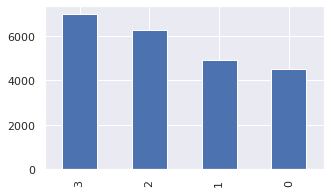

In [41]:
sns.set(rc= {'figure.figsize': (5,3)})
sns.set_style('darkgrid')

df_orig.major_lda_topic.value_counts().plot(kind='bar')

In [42]:
df_orig.groupby(['klabels'])['major_lda_topic'].value_counts(ascending=False, normalize=True)

klabels  major_lda_topic
0        3                  0.314492
         2                  0.253064
         1                  0.220187
         0                  0.212257
1        2                  0.390520
         3                  0.247630
         1                  0.212717
         0                  0.149133
2        3                  0.374717
         0                  0.248299
         1                  0.218254
         2                  0.158730
Name: major_lda_topic, dtype: float64

### Deriving Conclusions- Looking at the data

In [43]:
num_cols= ['Age','Positive_Feedback_Count','rev_word_count', 'unique_word_count','total_sentiment_score']

cat_cols= ['major_lda_topic','Division_Name','Department_Name','Class_Name']

cluster1= df_orig.loc[(df_orig.klabels==0)]
cluster2= df_orig.loc[(df_orig.klabels==1)]
cluster3= df_orig.loc[(df_orig.klabels==2)]

**Cluster 1 Analysis**

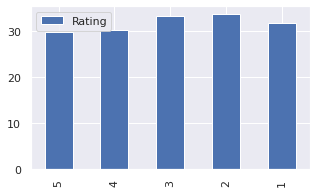

In [44]:
pd.DataFrame((cluster1.Rating.value_counts()*100)/df_orig.Rating.value_counts()).plot(kind='bar')

Visualizing numerical features:


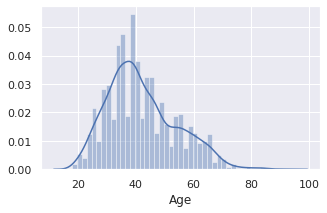

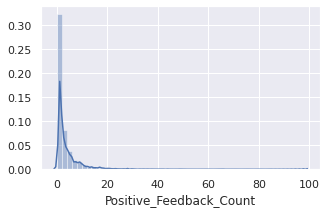

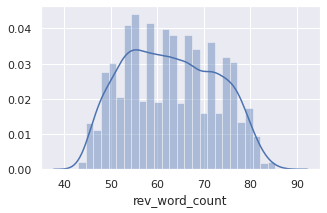

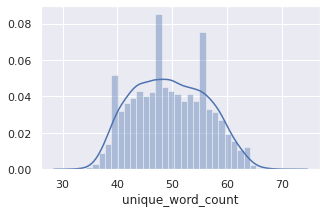

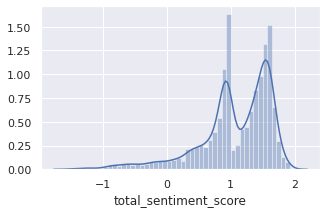

In [45]:
print('Visualizing numerical features:')
for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(cluster1[col])


Visualizing categorical features:


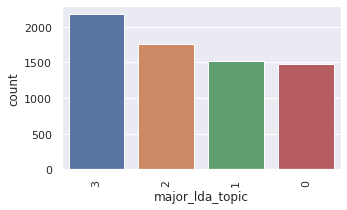

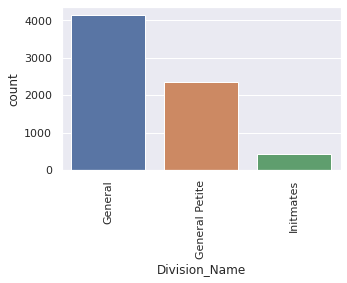

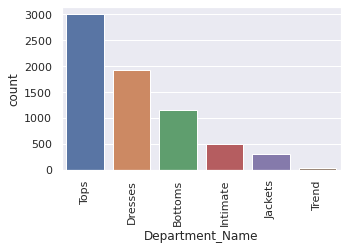

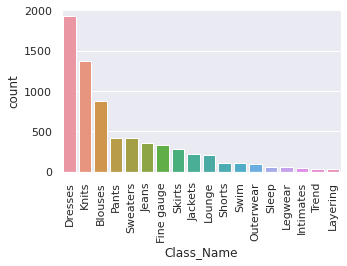

In [46]:
print('Visualizing categorical features:')
for i, col in enumerate(cat_cols):
    plt.figure(i)
    chart= sns.countplot(cluster1[col], order= cluster1[col].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

Visualizing numerical features:


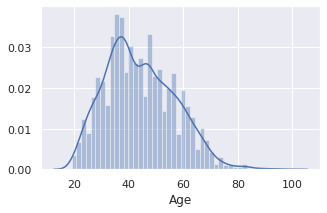

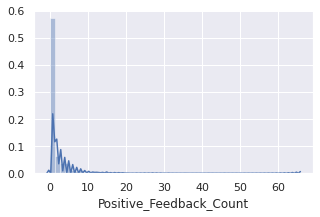

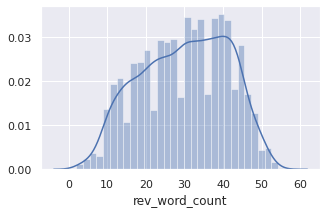

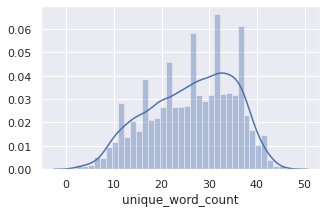

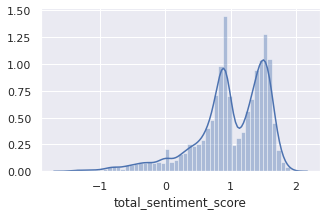

In [47]:
# **Cluster 2 Analysis**
print('Visualizing numerical features:')
for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(cluster2[col])

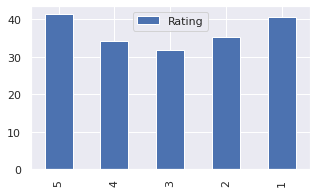

In [48]:
pd.DataFrame((cluster2.Rating.value_counts()*100)/df_orig.Rating.value_counts()).plot(kind='bar')

Visualizing categorical features:


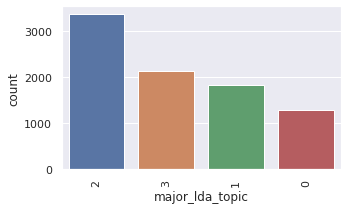

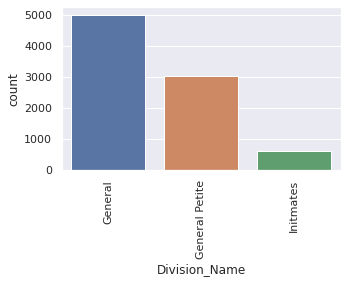

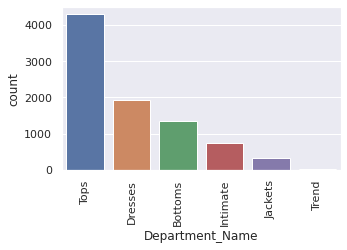

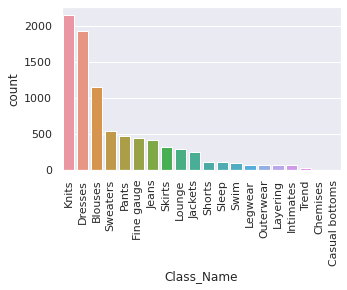

In [49]:
print('Visualizing categorical features:')
for i, col in enumerate(cat_cols):
    plt.figure(i)
    chart= sns.countplot(cluster2[col], order= cluster2[col].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

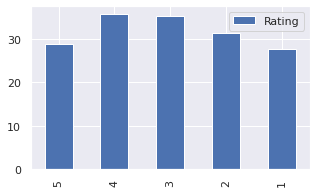

In [50]:
# Cluster 3 Analysis
pd.DataFrame((cluster3.Rating.value_counts()*100)/df_orig.Rating.value_counts()).plot(kind='bar')

Visualizing numerical features:


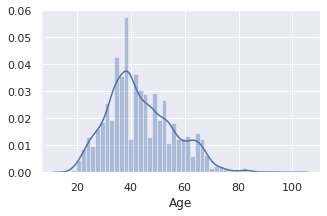

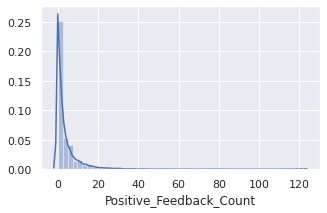

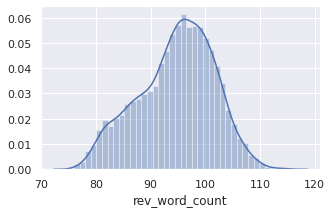

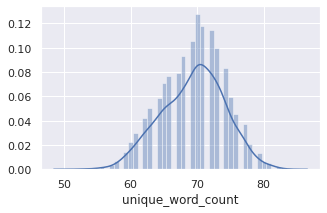

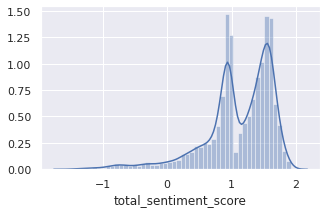

In [51]:
print('Visualizing numerical features:')
for i, col in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(cluster3[col])


Visualizing categorical features:


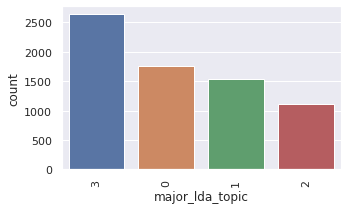

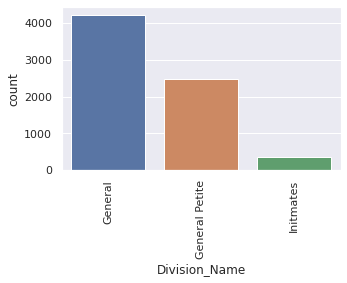

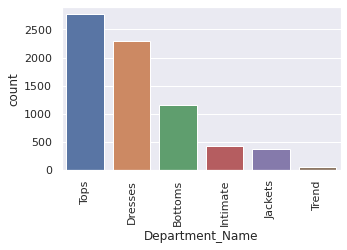

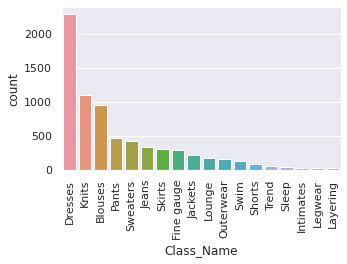

In [52]:
print('Visualizing categorical features:')
for i, col in enumerate(cat_cols):
    plt.figure(i)
    chart= sns.countplot(cluster3[col], order= cluster3[col].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

## INSIGHTS- CLUSTER AND TOPIC ANALYSIS

<img src="https://media.giphy.com/media/uBfr9DFs9vc40/giphy.gif">

**Repeating this analysis for each cluster and summarizing the graphs, We obtain the following observations:**

**Cluster 1 contains reviews having:**
- Young/Middle-aged women(age group 25-40) who have written descriptive reviews(50-80 words).
- Reviews are related to topic 3(31%),2,1. 

**Cluster 2 contains reviews having:**
- Middle/Elderly women(age group 35-60) who have written rather precise reviews(10-40 words).
- Reviews are related to topic 2(~40%),3,1. 

**Cluster 3 contains reviews having:**
- All age groups inclusive(25-60) who have written very detailed reviews(80-110 words).
- Reviews are related to topic 3(~37%),0,1. 


**Understanding Topics:**

**topic 0 contains reviews having:**
- Reviews are related to Dress, jackets, skirts. 
- Concerning stuff: casual/work wear, look, color, fit.

**topic 1 contains reviews having:**
- Reviews are related to bottomwear such as Jeans, pant, denim, skirts
- Concerning stuff: Stretch, skinny, short

**topic 2 contains reviews having:**
- Reviews are related to Topwear- shirt, sweater, jacket.
- Concerning stuff: Fabric, white, material, color, sleeve, arm, blue, boxy

**topic 3 contains reviews having:**
- Reviews are related to size related-issues- return!
- Concerning stuff: Small, petite, large, medium, regular, little, short, tight
- Related to- waist, bust, hip, shoulder!

<img src="https://media.giphy.com/media/lD76yTC5zxZPG/giphy.gif">


**Here my little attempt on NLP comes to end**

**Thanks for reading my kernel!**

**If you have any doubts or suggestions for improving my analysis, do let me know in the comments!**

**If you liked my kernel, do upvote!**

**Take care!**

References:

PFB few amazing blogs and notebooks : 

https://www.kaggle.com/adhok93/understanding-age-wise-sentiments-using-k-means <br>
https://www.kaggle.com/maksimeren/covid-19-literature-clustering/notebook <br>
https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/4-Topic-Modeling.ipynb <br>
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b<br>
https://distill.pub/2016/misread-tsne/ <br>
Understanding LDA:<br>
http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/ <br>